# Hong Kong Horse Racing

### Purpose

The purpose of this notebook is to be able to predict the outcome of horse races in Hong Kong.

### Structure of Notebook

* Import the data
* Create features
    * Win-odds Probability
    * True Skill Rankings
    * Elapsed time since previous race
    * Horse, Jockey, and Trainer Winning Percentages
    * Weight Change from Previous Race
    * Horse's Average, Maximum, and Minimum Speeds from Previous Races
    * Previous Finishing Position at Same Distance
* Visuals for Presentation
* Models
    * Decision Tree
    * Logistic Regression
    * Random Forest
    * SVM
    * Ada Boost
    * Gradient Boost

Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.metrics import plot_roc_curve
from category_encoders import OneHotEncoder

from sklearn.preprocessing import KBinsDiscretizer

from trueskill import Rating, quality_1vs1, rate_1vs1

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

Merge all data into a single dataframe.

In [3]:
horse = pd.read_csv('race_result_horse.csv')

In [4]:
race = pd.read_csv('race_result_race.csv')

In [5]:
race.columns

Index(['src', 'race_date', 'race_course', 'race_number', 'race_id',
       'race_class', 'race_distance', 'track_condition', 'race_name', 'track',
       'sectional_time', 'incident_report'],
      dtype='object')

In [6]:
del race['incident_report']

In [7]:
profiles = pd.read_csv('horse_profiles_2.csv', index_col = 0)

In [8]:
horse = horse.merge(race, on='race_id', how='left')

In [9]:
horse = horse.merge(profiles, on='horse_id', how='left')

Remove data that I don't want think will be helpful.

In [10]:
del horse['src']; del horse['import_type']; del horse['age']; 
del horse['sectional_time']; del horse['length_behind_winner']; del horse['race_name']; 
del horse['color']; del horse['sex']; del horse['dam']; del horse['dam_sire']; del horse['horse_id'];

In [11]:
for i in range(1,7):
    del horse['running_position_{}'.format(i)]

### Create Target (Finishing 1st)

We decided to start our modelling with the simply goal of predicting which horse will come in first place.

In [12]:
target = 'win'
horse[target] = (horse['finishing_position'].isin(['1', '1 DH'])).astype(np.int)

In [13]:
horse.drop(index = 17242, inplace = True)

In [14]:
horse.drop(index = 11053, inplace = True)

# Feature Engineering

### Win Odds Probability

I created a feature that turned the betting odds into a public expectations probability of which horse will win.

In [15]:
horse.shape

(30187, 21)

In [16]:
horse = horse[horse['win_odds'] != '---']

In [17]:
horse['win_odds'] = horse['win_odds'].astype(float)

In [18]:
unique_race_ids = list(horse['race_id'].unique())

In [19]:
horse_win_odds_prob = []
for i in unique_race_ids:
    race = horse[horse.race_id == i]
    race_win_odds = race.win_odds
    inverse_odds = race_win_odds.map(lambda x: 1/x)
    inverse_odds_sum = inverse_odds.sum()
    scaled_inverse_odds = list(inverse_odds.map(lambda x: x/inverse_odds_sum))
    horse_names = list(race.horse_name)
    len_horses = list(range(len(horse_names)))
    dates = list(race.race_date)
    for x in len_horses:
        new_horse = {'horse_name': horse_names[x], 'win_odds_prob': scaled_inverse_odds[x], 'race_date': dates[x]}
        horse_win_odds_prob.append(new_horse)

In [20]:
df = pd.DataFrame(horse_win_odds_prob)

In [21]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [22]:
horse.shape

(29598, 22)

In [23]:
horse['finish_time'] = horse['finish_time'].str.split('.')

In [24]:
horse = horse[horse['finish_time'].apply(lambda x: len(x)) == 3]

In [25]:
horse['finish_time'] = horse['finish_time'].apply(lambda x: int(x[0])*60.0 + int(x[1]) + int(x[2])*0.01)

In [26]:
horse['speed'] = horse['race_distance'] / horse['finish_time']

### Horse TrueSkill

I used a ranking system that continuously updates with each race a horse runs.

In [28]:
from trueskill import Rating, quality_1vs1, rate_1vs1

In [29]:
horse = horse.replace(to_replace =["1 DH"], value ="1")
horse = horse.replace(to_replace =["2 DH"], value ="2")
horse = horse.replace(to_replace =["3 DH"], value ="3")
horse = horse.replace(to_replace =["4 DH"], value ="4")
horse = horse.replace(to_replace =["5 DH"], value ="5")
horse = horse.replace(to_replace =["6 DH"], value ="6")
horse = horse.replace(to_replace =["7 DH"], value ="7")
horse = horse.replace(to_replace =["8 DH"], value ="8")
horse = horse.replace(to_replace =["9 DH"], value ="9")
horse = horse.replace(to_replace =["10 DH"], value ="10")
horse = horse.replace(to_replace =["11 DH"], value ="11")
horse = horse.replace(to_replace =["12 DH"], value ="12")
horse = horse.replace(to_replace =["13 DH"], value ="13")
horse = horse.replace(to_replace =["14 DH"], value ="14")
horse = horse[horse.finishing_position != 'WV']
horse = horse[horse.finishing_position != 'TNP']
horse = horse[horse.finishing_position != 'DISQ']
horse = horse[horse.finishing_position != 'WX-A']
horse = horse[horse.finishing_position != 'DNF']
horse = horse[horse.finishing_position != 'WV-A']
horse = horse[horse.finishing_position != 'WX']
horse = horse[horse.finishing_position != 'PU']
horse = horse[horse.finishing_position != 'UR']
horse = horse[horse.finishing_position != 'FE']

In [30]:
horse['finishing_position'] = horse['finishing_position'].astype(int)

In [31]:
import trueskill
ts = trueskill.TrueSkill()
horses = horse['horse_name'].unique().ravel()
rating_dict = dict()
for x in horses:
    rating_dict[x] = ts.create_rating()
race_groups = horse.groupby('race_id')
def update_ratings(new_ratings, rating_dict):
    for key in new_ratings.keys():
        rating_dict[key] = new_ratings[key]
    return rating_dict
feature_list = []
mu_list = []
sigma_list = []
k_list = []
true_skill_dicts = []
for i, group in enumerate(race_groups):
    horse_ids = group[1]['horse_name'].values.tolist()
    date = group[1]['race_date'].values.tolist()[0]
    horse_dict = [(rating_dict[k],) for k in horse_ids if k in rating_dict]
    for k in horse_ids:
        mu_list.append(rating_dict[k].mu)
        sigma_list.append(rating_dict[k].sigma)
        k_list.append(k)
        true_skill_values = {'mu_horse': rating_dict[k].mu, 'sigma_horse': rating_dict[k].sigma, 'horse_name': k, 'race_date' : date}
        true_skill_dicts.append(true_skill_values)
        
    # for ranks 0 is winner
    ranks = (group[1]['finishing_position']-1).astype(np.int).values.tolist()
    updated_horses = ts.rate(horse_dict, ranks=ranks)
    updated_horses = dict(zip(horse_ids,list(sum(updated_horses, ()))))    
    # update the rating dictionary
    rating_dict = update_ratings(updated_horses, rating_dict)

In [32]:
# rating_dict

In [33]:
df = pd.DataFrame(true_skill_dicts)

In [34]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [36]:
horse['horse_rank'] = horse.mu_horse - (3 * horse.sigma_horse)

### Jockey TrueSkill

I repeated the ranking technique for jockeys, however it is not currently working properly.

In [38]:
import trueskill
ts = trueskill.TrueSkill()
jockeys = horse['jockey'].unique().ravel()
rating_dict = dict()
for x in jockeys:
    rating_dict[x] = ts.create_rating()
race_groups = horse.groupby('race_id')
def update_ratings(new_ratings, rating_dict):
    for key in new_ratings.keys():
        rating_dict[key] = new_ratings[key]
    return rating_dict
feature_list = []
mu_list = []
sigma_list = []
k_list = []
true_skill_dicts = []
for i, group in enumerate(race_groups):
    jockey_ids = group[1]['jockey'].values.tolist()
    date = group[1]['race_date'].values.tolist()[0]
    horse_id = group[1]['horse_name'].values.tolist()
    jockey_dict = [(rating_dict[k],) for k in jockey_ids if k in rating_dict]
    for x, k in enumerate(jockey_ids):
        mu_list.append(rating_dict[k].mu)
        sigma_list.append(rating_dict[k].sigma)
        k_list.append(k)
        true_skill_values = {'mu_jockey': rating_dict[k].mu, 'sigma_jockey': rating_dict[k].sigma, 'race_date' : date, 'jockey': k, 'horse_name':horse_id[x]}
        true_skill_dicts.append(true_skill_values)
        
    # for ranks 0 is winner
    ranks = (group[1]['finishing_position']-1).astype(np.int).values.tolist()
    updated_horses = ts.rate(jockey_dict, ranks=ranks)
    updated_horses = dict(zip(jockey_ids,list(sum(updated_horses, ()))))    
    # update the rating dictionary
    rating_dict = update_ratings(updated_horses, rating_dict)

In [39]:
df = pd.DataFrame(true_skill_dicts)

In [42]:
horse = horse.merge(df, on=['horse_name', 'race_date', 'jockey'], how='left')

In [45]:
horse['jockey_rank'] = horse.mu_jockey - (3 * horse.sigma_jockey)

### Elapsed Time Since Previous Race

I created a feature that checks how long it has been since the horse last ran in a race. The thinking behind this was that it is possible that if it is too soon since a horse previously ran, the horse could be tired, or if it is too long since the horse has run, it could be out of shape. The potential flaw in this thinking is that the horse could be undergoing training during a long layoff and the trainer could be waiting to unleash the horse until they think that it is ready.

In [47]:
horse['race_date'] = pd.to_datetime(horse['race_date'], format='%Y-%m-%d', errors='ignore')

In [48]:
list_of_horses = list(horse.horse_name.unique())
horse_time_since_by_race = []
for i in list_of_horses:
    time_since_last_race = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'].diff())
    len_dates = list(range(len(time_since_last_race)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_dates:
        new_horse = {'horse_name': i, 'days_since_last_race': time_since_last_race[x], 'race_date': dates[x]}
        horse_time_since_by_race.append(new_horse)

In [49]:
df = pd.DataFrame(horse_time_since_by_race)

In [50]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [51]:
horse['days_since_last_race'] = horse['days_since_last_race'].astype(int)/(24*60*60*(10**9))

### Keep only 1200m Races

Since some of our data is based on speeds, I decided to look only at one race distance at a time. Presumably, longer races will involve slower speeds and it would potentially affect the predictions.

In [52]:
horse = horse[horse.race_distance == 1200]

### Horse Winning Percentage

I calculated the winning percentages of each the horse, jockey, and trainer.

In [53]:
list_of_horses = list(horse.horse_name.unique())
winning_percentage = []
for i in list_of_horses:
    wins = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['win'].cumsum().shift())
    races = list(range(len(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['win'])))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    len_races = list(range(len(races)))
    for x in len_races:
        try:
            win_perc = wins[x]/races[x]
            new_horse = {'horse_name': i, 'horse_win_perc': win_perc, 'race_date': dates[x]}
            winning_percentage.append(new_horse)
        except:
            new_horse = {'horse_name': i, 'horse_win_perc': None, 'race_date': dates[x]}
            winning_percentage.append(new_horse)

In [54]:
df = pd.DataFrame(winning_percentage)

In [55]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [56]:
horse.shape

(9923, 31)

### Jockey Winning Percentage

In [57]:
list_of_jockeys = list(horse.jockey.unique())
winning_percentage = []
for i in list_of_jockeys:
    wins = list(horse.loc[horse['jockey'] == i].sort_values(by = ['race_date'])['win'].cumsum().shift())
    races = list(range(len(horse.loc[horse['jockey'] == i].sort_values(by = ['race_date'])['win'])))
    dates = list(horse.loc[horse['jockey'] == i].sort_values(by = ['race_date'])['race_date'])
    horses = list(horse.loc[horse['jockey'] == i].sort_values(by = ['race_date'])['horse_name'])
    len_races = list(range(len(races)))
    for x in len_races:
        try:
            win_perc = wins[x]/races[x]
            new_jockey = {'jockey': i, 'jockey_win_perc': win_perc, 'race_date': dates[x], 'horse_name': horses[x]}
            winning_percentage.append(new_jockey)
        except:
            new_jockey = {'jockey': i, 'jockey_win_perc': None, 'race_date': dates[x], 'horse_name': horses[x]}
            winning_percentage.append(new_jockey)

In [58]:
df = pd.DataFrame(winning_percentage)

In [59]:
horse = horse.merge(df, on=['horse_name', 'race_date', 'jockey'], how='left')

### Trainer Winning Percentage

In [61]:
list_of_trainers = list(horse.trainer.unique())
winning_percentage_trainer = []
for i in list_of_trainers:
    wins = list(horse.loc[horse['trainer'] == i].sort_values(by = ['race_date'])['win'].cumsum().shift())
    races = list(range(len(horse.loc[horse['trainer'] == i].sort_values(by = ['race_date'])['win'])))
    dates = list(horse.loc[horse['trainer'] == i].sort_values(by = ['race_date'])['race_date'])
    horses = list(horse.loc[horse['trainer'] == i].sort_values(by = ['race_date'])['horse_name'])
    len_races = list(range(len(races)))
    for x in len_races:
        try:
            win_perc_t = wins[x]/races[x]
            new_trainer = {'trainer': i, 'trainer_win_perc': win_perc_t, 'race_date': dates[x], 'horse_name': horses[x]}
            winning_percentage_trainer.append(new_trainer)
        except:
            new_trainer = {'trainer': i, 'trainer_win_perc': None, 'race_date': dates[x], 'horse_name': horses[x]}
            winning_percentage_trainer.append(new_trainer)

In [62]:
df = pd.DataFrame(winning_percentage_trainer)

In [63]:
horse = horse.merge(df, on=['horse_name', 'race_date', 'trainer'], how='left')

### Find Weight Change From Previous Race

I created a feature that checked how much a horse's weight had changed from the previous race because of the idea that if a horse gained a lot of weight it could be out of shape and if a horse lost weight it could be recovering from illness or could have lost some muscle mass.

In [65]:
horse = horse[horse['declared_horse_weight'] != '-']

In [66]:
list_of_horses = list(horse.horse_name.unique())
horse_weight_change_by_race = []
for i in list_of_horses:
    horse_weight_change = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['declared_horse_weight'].astype('int').pct_change())
    len_weights = list(range(len(horse_weight_change)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_weights:
        new_horse = {'horse_name': i, 'weight_change': horse_weight_change[x], 'race_date': dates[x]}
        horse_weight_change_by_race.append(new_horse)

In [67]:
df = pd.DataFrame(horse_weight_change_by_race)

In [68]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

### Encode Draw

In [200]:
gp = horse[['draw', target]].groupby('draw').mean().rename({target:'draw_encoded'},axis=1)

In [78]:
horse = horse.merge(gp, on='draw', how='left')

### Horse Average Speed/Relative Average Speed

In order to avoid using future data to predict a race, I created a column for average speed at a particular distance for each horse only using past data. I also found the average for each horse in a particular race and found how much each horse differed from the highest average speed.

In [81]:
list_of_horses = list(horse.horse_name.unique())
horse_average_speed_by_race = []
for i in list_of_horses:
    horse_speeds = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['speed'].expanding().mean().shift(1))
    len_speeds = list(range(len(horse_speeds)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_speeds:
        new_horse = {'horse_name': i, 'average_speed': horse_speeds[x], 'race_date': dates[x]}
        horse_average_speed_by_race.append(new_horse)

In [82]:
df = pd.DataFrame(horse_average_speed_by_race)

In [83]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [86]:
horse_relative_average_speed = []
for i in unique_race_ids:
    race = horse[horse.race_id == i]
    race_average_speed = race.average_speed.mean()
    average_speed_diff = list(-1 * (race.average_speed - race_average_speed))
    horse_names = list(race.horse_name)
    len_horses = list(range(len(horse_names)))
    dates = list(race.race_date)
    for x in len_horses:
        new_horse = {'horse_name': horse_names[x], 'average_speed_diff': average_speed_diff[x], 'race_date': dates[x]}
        horse_relative_average_speed.append(new_horse)

In [88]:
df = pd.DataFrame(horse_relative_average_speed)

In [89]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

### Max Speed Differential

I found the maximum speed that every horse had run at for every race and found the differential with the highest maximum speed in every race.

In [91]:
list_of_horses = list(horse.horse_name.unique())
horse_max_speed = []
for i in list_of_horses:
    horse_max_speeds = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['speed'].cummax().shift(1))
    len_speeds = list(range(len(horse_max_speeds)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_speeds:
        new_horse = {'horse_name': i, 'max_speed': horse_max_speeds[x], 'race_date': dates[x]}
        horse_max_speed.append(new_horse)

In [92]:
df = pd.DataFrame(horse_max_speed)

In [93]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [94]:
unique_race_ids = list(horse.race_id.unique())

In [95]:
horse_relative_max_speed = []
for i in unique_race_ids:
    race = horse[horse.race_id == i]
    race_max_speed = race.max_speed.max()
    max_speed_diff = list(-1 * (race.max_speed - race_max_speed))
    horse_names = list(race.horse_name)
    len_horses = list(range(len(horse_names)))
    dates = list(race.race_date)
    for x in len_horses:
        new_horse = {'horse_name': horse_names[x], 'max_speed_diff': max_speed_diff[x], 'race_date': dates[x]}
        horse_relative_max_speed.append(new_horse)

In [96]:
df = pd.DataFrame(horse_relative_max_speed)

In [97]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

### Min Speed Differential

I repeated the step from above with minimum speed.

In [99]:
list_of_horses = list(horse.horse_name.unique())
horse_min_speed = []
for i in list_of_horses:
    horse_min_speeds = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['speed'].cummin().shift(1))
    len_speeds = list(range(len(horse_min_speeds)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_speeds:
        new_horse = {'horse_name': i, 'min_speed': horse_min_speeds[x], 'race_date': dates[x]}
        horse_min_speed.append(new_horse)

In [100]:
df = pd.DataFrame(horse_min_speed)

In [101]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

In [102]:
horse_relative_min_speed = []
for i in unique_race_ids:
    race = horse[horse.race_id == i]
    race_min_speed = race.min_speed.min()
    min_speed_diff = list(race.min_speed - race_min_speed)
    horse_names = list(race.horse_name)
    len_horses = list(range(len(horse_names)))
    dates = list(race.race_date)
    for x in len_horses:
        new_horse = {'horse_name': horse_names[x], 'min_speed_diff': min_speed_diff[x], 'race_date': dates[x]}
        horse_relative_min_speed.append(new_horse)

In [103]:
df = pd.DataFrame(horse_relative_min_speed)

In [104]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

### Find Horse Weight at Max Speed

Here I was attempting to find the weight at which the horse ran at its fasted speed, however I was unable to get the code to work before the conclusion of the project.

In [114]:
# horse.columns

In [115]:
# import math

In [116]:
# list_of_horses = list(horse.horse_name.unique())
# max_speed_weight = []
# # for i in list_of_horses:
# horse_max_speeds = list(horse.loc[horse['horse_name'] == 'LUCKY BUBBLES'].sort_values(by = ['race_date'])['speed'].cummax().shift(1))
# horse_speeds = list(horse.loc[horse['horse_name'] == 'LUCKY BUBBLES'].sort_values(by = ['race_date'])['speed'].shift(1))
# horse_weights = list(horse.loc[horse['horse_name'] == 'LUCKY BUBBLES'].sort_values(by = ['race_date'])['declared_horse_weight'].shift(1))

# print(horse_max_speeds)
# print(horse_speeds)
# print(horse_weights)
# # num_of_races = list(range(len(horse_max_speeds)))
# # for x in num_of_races:
# #     if math.isnan(horse_max_speeds[x]):
# #         max_speed_weight.append[None]
# #     elif horse_max_speeds[x] == horse_speeds[x]:
# #         k = x
# #         max_speed_weight.append[horse_weights[x]]
# #     elif horse_max_speeds[x] > horse_speeds[x]:
# #         max_speed_weight.append[horse_weights[k]]

# # len_speeds = list(range(len(horse_max_speeds)))
# # dates = list(horse.loc[horse['horse_name'] == 'MASSIVE'].sort_values(by = ['race_date'])['race_date'])
# # for x in len_speeds:
# #     new_horse = {'horse_name': 'MASSIVE', 'max_speed': horse_max_speeds[x], 'race_date': dates[x]}
# #     horse_max_speed.append(new_horse)

In [117]:
# print(horse_max_speed)

In [118]:
# horse.loc[horse['horse_name'] == 'MASSIVE'].sort_values(by = ['race_date'])

In [119]:
# max_speed_weights

### Previous Finishing Position at Same Distance

I created a feature that found the previous finishing position for each horse with the idea that a horse who as done well recently will most likely continue to do well, and vice versa.

In [106]:
list_of_horses = list(horse.horse_name.unique())
previous_finishing_position = []
for i in list_of_horses:
    prev_fin_pos = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['finishing_position'].shift())
    len_pos = list(range(len(prev_fin_pos)))
    dates = list(horse.loc[horse['horse_name'] == i].sort_values(by = ['race_date'])['race_date'])
    for x in len_pos:
        new_horse = {'horse_name': i, 'previous_finishing_position': prev_fin_pos[x], 'race_date': dates[x]}
        previous_finishing_position.append(new_horse)

In [107]:
df = pd.DataFrame(previous_finishing_position)

In [108]:
horse = horse.merge(df, on=['horse_name', 'race_date'], how='left')

### Cleaning the Data

Here, I removed the null values from the data.

In [111]:
horse = horse[horse.average_speed.notnull()]

In [112]:
horse = horse[horse.jockey_win_perc.notnull()]

In [113]:
horse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8274 entries, 144 to 9922
Data columns (total 42 columns):
finishing_position             8274 non-null int64
horse_number                   8274 non-null float64
horse_name                     8274 non-null object
jockey                         8274 non-null object
trainer                        8274 non-null object
actual_weight                  8274 non-null object
declared_horse_weight          8274 non-null object
draw                           8274 non-null object
finish_time                    8274 non-null float64
win_odds                       8274 non-null float64
race_id                        8274 non-null object
race_date                      8274 non-null datetime64[ns]
race_course                    8274 non-null object
race_number                    8274 non-null int64
race_class                     8274 non-null object
race_distance                  8274 non-null int64
track_condition                8274 non-null object

### Visuals

I created some visuals to use for the project presentation.

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [168]:
horse.head()

,finishing_position,horse_number,horse_name,jockey,trainer,actual_weight,declared_horse_weight,draw,finish_time,win_odds,...,trainer_win_perc,weight_change,draw_encoded,average_speed,average_speed_diff,max_speed,max_speed_diff,min_speed,min_speed_diff,previous_finishing_position
144,4,7.0,CHEETAH BOY,C K Tong,Y S Tsui,118,1105,5,69.68,15.0,...,0.166667,-0.004505,0.104551,17.286085,-0.102006,17.286085,-0.000000,17.286085,0.165240,3.0
145,5,8.0,EN CIVIL,K Teetan,R Gibson,119,1087,2,70.08,35.0,...,0.000000,-0.012716,0.101235,17.120845,0.063234,17.120845,0.165240,17.120845,0.000000,10.0
149,9,9.0,G-ONE LEADER,T H So,C H Yip,115,1012,1,70.78,44.0,...,0.000000,-0.005894,0.134734,17.145306,0.038772,17.145306,0.140778,17.145306,0.024462,9.0
151,1,5.0,GRAND PLUS,J Moreira,J Size,123,1073,6,69.53,2.2,...,0.166667,0.000000,0.079110,17.328520,-0.301760,17.328520,-0.000000,17.328520,0.627058,2.0
153,3,1.0,MEDIC KINGDOM,K Teetan,A T Millard,133,1138,7,70.27,15.0,...,0.125000,-0.007847,0.065351,17.050298,-0.023539,17.050298,0.278221,17.050298,0.348837,9.0


In [172]:
corr_matrix = abs(horse.corr())

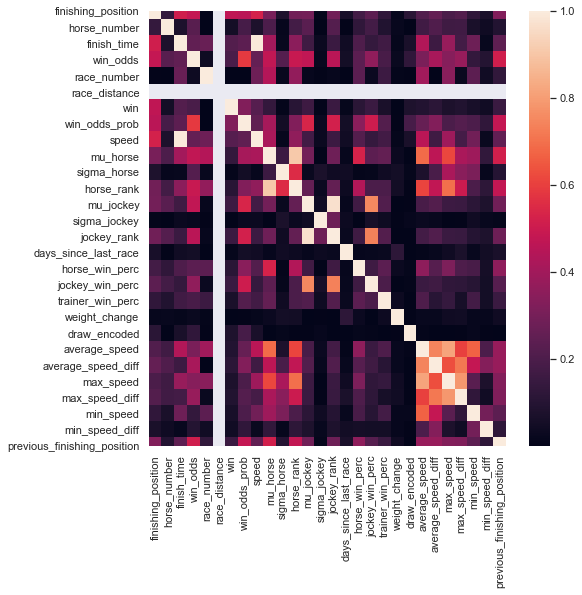

In [173]:
plt.figure(figsize = (8,8))
sns.heatmap(corr_matrix)

In [177]:
a = horse['draw'].astype(int)

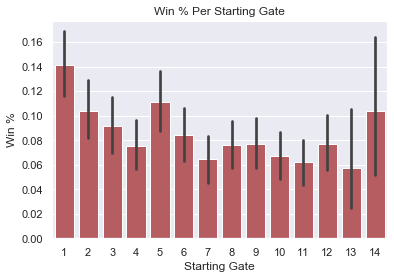

In [203]:
sns.barplot(a,horse['win'], color = 'r')
plt.title("Win % Per Starting Gate")
plt.xlabel("Starting Gate")
plt.ylabel("Win %")
plt.show()

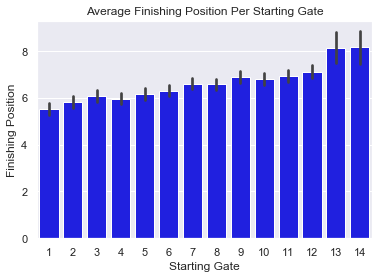

In [204]:
sns.barplot(a, horse['finishing_position'], color = 'blue')
plt.title("Average Finishing Position Per Starting Gate")
plt.xlabel("Starting Gate")
plt.ylabel("Finishing Position")
plt.show()

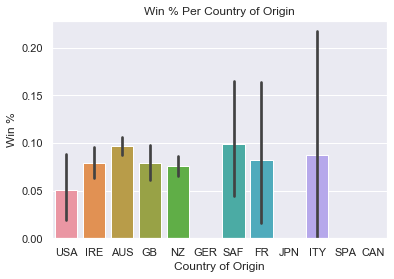

In [193]:
sns.barplot(horse['origin'],horse['win'])
plt.title("Win % Per Country of Origin")
plt.xlabel("Country of Origin")
plt.ylabel("Win %")
plt.show()

In [262]:
horse['draw'] = horse['draw'].astype(int)

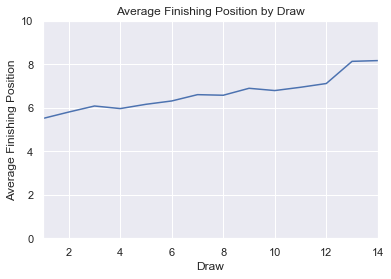

In [273]:
df_2 = horse.groupby('draw')['finishing_position'].mean()

df_2.plot(x='draw',y='finishing_position')
plt.ylim(0, 10)
plt.title("Average Finishing Position by Draw")
plt.xlabel("Draw")
plt.ylabel("Average Finishing Position")
plt.show()

In [231]:
horse['declared_horse_weight'] = horse['declared_horse_weight'].astype(int)

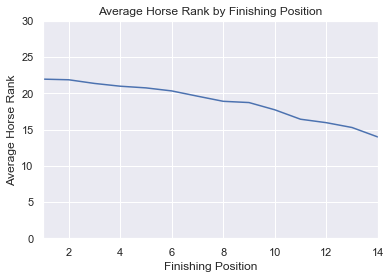

In [268]:
df_2 = horse.groupby('finishing_position')['horse_rank'].mean()

df_2.plot(x='finishing_position',y='horse_rank')
plt.ylim(0, 30)
plt.title("Average Horse Rank by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Horse Rank")
plt.show()

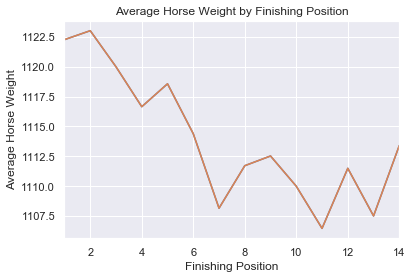

In [240]:
df_2 = horse.groupby('finishing_position')['declared_horse_weight'].mean()

df_2.plot(x='finishing_position',y='declared_horse_weight')
plt.title("Average Horse Weight by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Horse Weight")
plt.show()

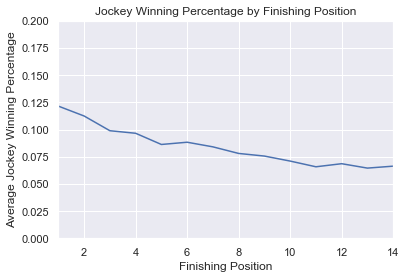

In [279]:
df_2 = horse.groupby('finishing_position')['jockey_win_perc'].mean()
df_2.plot(x='finishing_position',y='jockey_win_perc')
plt.ylim(0, 0.2)
plt.title("Jockey Winning Percentage by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Jockey Winning Percentage")
plt.show()

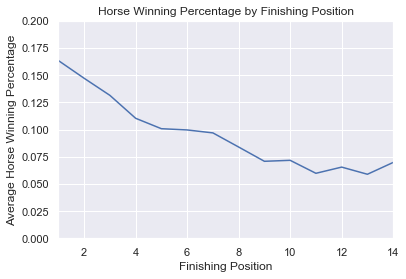

In [280]:
df_2 = horse.groupby('finishing_position')['horse_win_perc'].mean()
df_2.plot(x='finishing_position',y='horse_win_perc')
plt.ylim(0, 0.2)
plt.title("Horse Winning Percentage by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Horse Winning Percentage")
plt.show()

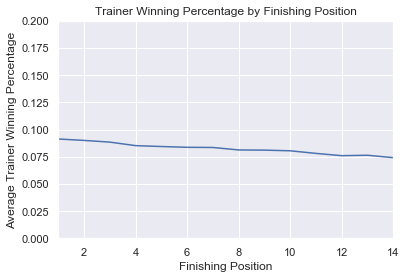

In [281]:
df_2 = horse.groupby('finishing_position')['trainer_win_perc'].mean()
df_2.plot(x='finishing_position',y='trainer_win_perc')
plt.ylim(0, 0.2)
plt.title("Trainer Winning Percentage by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Trainer Winning Percentage")
plt.show()

In [244]:
horse['actual_weight'] = horse['actual_weight'].astype(int)

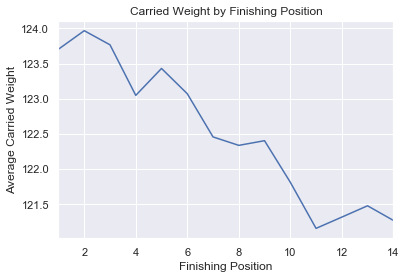

In [275]:
df_2 = horse.groupby('finishing_position')['actual_weight'].mean()
df_2.plot(x='finishing_position',y='actual_weight')
plt.title("Carried Weight by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Carried Weight")
plt.show()

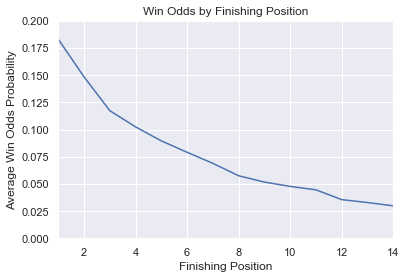

In [274]:
df_2 = horse.groupby('finishing_position')['win_odds_prob'].mean()
df_2.plot(x='finishing_position',y='win_odds_prob')
plt.ylim(0, 0.2)
plt.title("Win Odds by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Win Odds Probability")
plt.show()

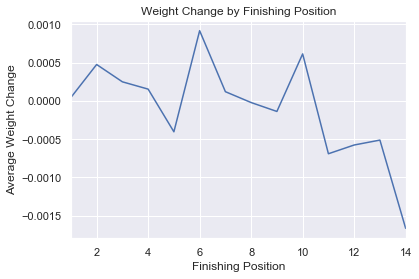

In [251]:
df_2 = horse.groupby('finishing_position')['weight_change'].mean()
df_2.plot(x='finishing_position',y='weight_change')
plt.title("Weight Change by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Weight Change")
plt.show()

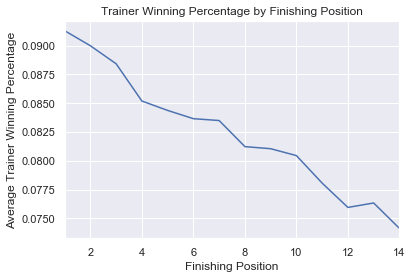

In [252]:
df_2 = horse.groupby('finishing_position')['trainer_win_perc'].mean()
df_2.plot(x='finishing_position',y='trainer_win_perc')
plt.title("Trainer Winning Percentage by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Trainer Winning Percentage")
plt.show()

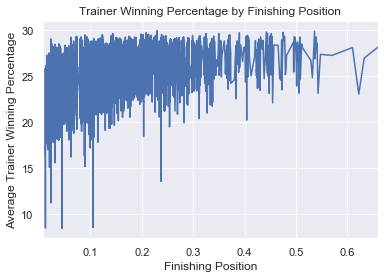

In [272]:
df_2 = horse.groupby('win_odds_prob')['jockey_rank'].mean()
df_2.plot(x='win_odds_prob',y='jockey_rank')
plt.title("Trainer Winning Percentage by Finishing Position")
plt.xlabel("Finishing Position")
plt.ylabel("Average Trainer Winning Percentage")
plt.show()

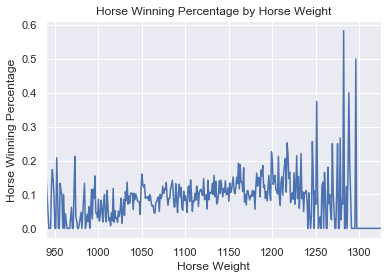

In [259]:
df_2 = horse.groupby('declared_horse_weight')['horse_win_perc'].mean()
df_2.plot(x = 'declared_horse_weight',y = 'horse_win_perc')
plt.title("Horse Winning Percentage by Horse Weight")
plt.xlabel("Horse Weight")
plt.ylabel("Horse Winning Percentage")
plt.show()

In [181]:
horse.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'jockey', 'trainer',
       'actual_weight', 'declared_horse_weight', 'draw', 'finish_time',
       'win_odds', 'race_id', 'race_date', 'race_course', 'race_number',
       'race_class', 'race_distance', 'track_condition', 'track', 'origin',
       'sire', 'win', 'win_odds_prob', 'speed', 'mu_horse', 'sigma_horse',
       'horse_rank', 'mu_jockey', 'sigma_jockey', 'jockey_rank',
       'days_since_last_race', 'horse_win_perc', 'jockey_win_perc',
       'trainer_win_perc', 'weight_change', 'draw_encoded', 'average_speed',
       'average_speed_diff', 'max_speed', 'max_speed_diff', 'min_speed',
       'min_speed_diff', 'previous_finishing_position'],
      dtype='object')

In [243]:
horse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8274 entries, 144 to 9922
Data columns (total 42 columns):
finishing_position             8274 non-null int64
horse_number                   8274 non-null float64
horse_name                     8274 non-null object
jockey                         8274 non-null object
trainer                        8274 non-null object
actual_weight                  8274 non-null object
declared_horse_weight          8274 non-null int64
draw                           8274 non-null object
finish_time                    8274 non-null float64
win_odds                       8274 non-null float64
race_id                        8274 non-null object
race_date                      8274 non-null datetime64[ns]
race_course                    8274 non-null object
race_number                    8274 non-null int64
race_class                     8274 non-null object
race_distance                  8274 non-null int64
track_condition                8274 non-null object


# Modeling

### Decision Tree

In [131]:
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [115]:
horse.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'jockey', 'trainer',
       'actual_weight', 'declared_horse_weight', 'draw', 'finish_time',
       'win_odds', 'race_id', 'race_date', 'race_course', 'race_number',
       'race_class', 'race_distance', 'track_condition', 'track', 'origin',
       'sire', 'win', 'win_odds_prob', 'speed', 'mu_horse', 'sigma_horse',
       'horse_rank', 'mu_jockey', 'sigma_jockey', 'jockey_rank',
       'days_since_last_race', 'horse_win_perc', 'jockey_win_perc',
       'trainer_win_perc', 'weight_change', 'draw_encoded', 'average_speed',
       'average_speed_diff', 'max_speed', 'max_speed_diff', 'min_speed',
       'min_speed_diff', 'previous_finishing_position'],
      dtype='object')

In [126]:
N=3
dt = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', 
                            random_state=42, 
                            max_depth=N, max_leaf_nodes=2**N-1)

imputer = SimpleImputer()
dt_pipe = make_pipeline(imputer, dt)

used_cols = ['draw_encoded', 'race_number', 'max_speed_diff', 'min_speed_diff', 'horse_rank', 'jockey_win_perc','actual_weight', 'days_since_last_race', 'win_odds']
X, y = horse[used_cols], horse[target]

scores = cross_val_score(dt_pipe, X.values, y.values, cv=5, scoring='roc_auc', n_jobs=-1)
scores.mean(), scores.std()

(0.7717660260328614, 0.025640466024998625)

In [158]:
N=3
dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                            random_state=42, 
                            max_depth=N, max_leaf_nodes=2**N-1)
imputer = SimpleImputer()
dt_pipe = make_pipeline(imputer, dt)

used_cols = ['draw_encoded', 'race_number', 'max_speed_diff', 'min_speed_diff', 'horse_rank', 'jockey_win_perc','actual_weight', 'days_since_last_race', 'win_odds']
X, y = horse[used_cols], horse[target]

scores = cross_val_score(dt_pipe, X.values, y.values, cv=5, scoring='roc_auc', n_jobs=-1)
scores.mean(), scores.std()

(0.770644530768352, 0.025739661886030798)

Gini appears to produce a higher AUC and a lower standard deviation.

### LogReg

In [127]:
cat_cols = ['track_condition', 'track', 'race_class']
num_cols = ['draw_encoded', 'race_number', 'max_speed_diff', 'min_speed_diff', 'horse_rank', 'jockey_win_perc','actual_weight', 'days_since_last_race', 'win_odds_prob']

In [128]:
used_cols = num_cols + cat_cols

In [133]:
num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_cols, handle_missing="value")

num_transformer = make_pipeline(num_imputer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])

model = LogisticRegression()

lr_pipe = make_pipeline(preprocessor, model)

X, y = horse[used_cols], horse[target]

scores = cross_val_score(lr_pipe, X, y, cv=5, scoring = 'roc_auc')
scores.mean(), scores.std()

(0.7773045569727846, 0.030766007759518824)

### Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [197]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', 
                            max_depth=8, min_samples_leaf=5, random_state=42, 
                            class_weight='balanced', n_jobs=-1)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7638081779879858 +/- 0.02980962325833098


In [187]:
rf = RandomForestClassifier()

grid_params = {'criterion' : ['gini', 'entropy'], 
              'n_estimators' : [10, 25, 50, 100], 
              'max_depth': [4, 6, 8, 10, 12], 
              'min_samples_leaf' : [1, 3, 5, 7]}
grid_search = GridSearchCV(rf, grid_params, cv = 3, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [188]:
rf_grid = grid_search.best_estimator_
rf_grid.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [199]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', 
                            max_depth=4, min_samples_leaf=7, random_state=42, 
                            class_weight='balanced', n_jobs=-1)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7738580093858992 +/- 0.026604119394645003


In [136]:
num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_cols, handle_missing="value")

num_transformer = make_pipeline(num_imputer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])

model = RandomForestClassifier(n_estimators=50, criterion='entropy', 
                            max_depth=4, min_samples_leaf=7, random_state=42, 
                            class_weight='balanced', n_jobs=-1)

rf_pipe = make_pipeline(preprocessor, model)

X, y = horse[used_cols], horse[target]

scores = cross_val_score(rf_pipe, X, y, cv=5, scoring = 'roc_auc')
scores.mean(), scores.std()

(0.7720182367297046, 0.026706207226906947)

Random Forest performed worse with encoded categorical data.

### LogReg 2 

In [143]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from category_encoders import WOEEncoder
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score

In [137]:
cat_cols = ['track_condition', 'track', 'race_class']
num_cols = ['draw_encoded', 'race_number', 'max_speed_diff', 'min_speed_diff', 'horse_rank', 'jockey_win_perc','actual_weight', 'days_since_last_race', 'win_odds_prob']

In [138]:
used_cols = num_cols + cat_cols
X, y = horse[used_cols], horse[target]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [140]:
num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_cols, handle_missing="value")

num_transformer = make_pipeline(num_imputer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])

model = LogisticRegression()

lr_pipe = make_pipeline(preprocessor, model)

lr_pipe.fit(X_train, y_train)

train_preds = lr_pipe.predict(X_train)
test_preds = lr_pipe.predict(X_test)

In [141]:
print("TRAIN:")
print(confusion_matrix(y_train, train_preds))
print('')
print("TEST:")
print(confusion_matrix(y_test, test_preds))

TRAIN:
[[5602   50]
 [ 511   42]]

TEST:
[[1890   19]
 [ 145   15]]


In [144]:
print("Accuracy:"); print("="*len("Accuracy:"))
print("TRAIN:", accuracy_score(y_train, train_preds))
print("TEST:", accuracy_score(y_test, test_preds))

Accuracy:
TRAIN: 0.9095890410958904
TEST: 0.9207346544224263


In [145]:
print("Balanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print("TRAIN:", balanced_accuracy_score(y_train, train_preds))
print("TEST:", balanced_accuracy_score(y_test, test_preds))

Balanced Accuracy:
TRAIN: 0.5335514705223646
TEST: 0.5418985725510739


In [147]:
train_preds = lr_pipe.predict_proba(X_train)[:,1]
test_preds = lr_pipe.predict_proba(X_test)[:,1]

print("AUC:"); print("="*len("AUC:"))
print("TRAIN:", roc_auc_score(y_train, train_preds))
print("TEST:", roc_auc_score(y_test, test_preds))

AUC:
====
TRAIN: 0.7843289321963836
TEST: 0.7625491094814039


### Support Vector Machine (SVM)

In [151]:
used_cols = ['draw_encoded', 'race_number', 'max_speed_diff', 'min_speed_diff', 'horse_rank', 'jockey_win_perc','actual_weight', 'days_since_last_race', 'win_odds']
X, y = horse[used_cols], horse[target]

In [152]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC

In [153]:
# used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
# X, y = df_10[used_cols], df_10[target]

svm = SVC(probability=True, class_weight='balanced', random_state=42)

scores = cross_val_score(svm, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7807590540541118 +/- 0.029166041137835302


### AdaBoost (Very Slow)

In [145]:
clf = AdaBoostClassifier(svm, n_estimators=50, 
                         learning_rate=0.1, random_state=42)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7609080495905245 +/- 0.032781309275707396


### Gradient Boosted Classifier

In [155]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.05, random_state=42, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7679734740089599 +/- 0.022059818490738937


In [156]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.01, random_state=42, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7762193765085372 +/- 0.024414924446882504


In [157]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.005, random_state=42, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7771058078794784 +/- 0.024645114444199423


Lowering the learning rate increases the mean AUC but also increases the standard deviation.